based on https://github.com/uygarkurt/DDPM-Image-Generation/blob/main/DDPM_Image_Generartion.ipynb

In [18]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import AdamW
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from datasets import load_dataset
from accelerate import Accelerator
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random 
import timeit

In [19]:
RANDOM_SEED = 42
IMG_SIZE = 128
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
NUM_GENERATE_IMAGES = 9
NUM_TIMESTEPS = 1000
MIXED_PRECISION = "fp16"
GRADIENT_ACCUMULATION_STEPS = 1

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
# torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
local_dataset_path = f"data/square{IMG_SIZE}_random0.1/"
dataset = load_dataset('imagefolder', data_dir=local_dataset_path)


Resolving data files:   0%|          | 0/30312 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [21]:
dataset = dataset['train']

C:\Users\adamm\AppData\Local\Temp\ipykernel_4140\2340717843.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


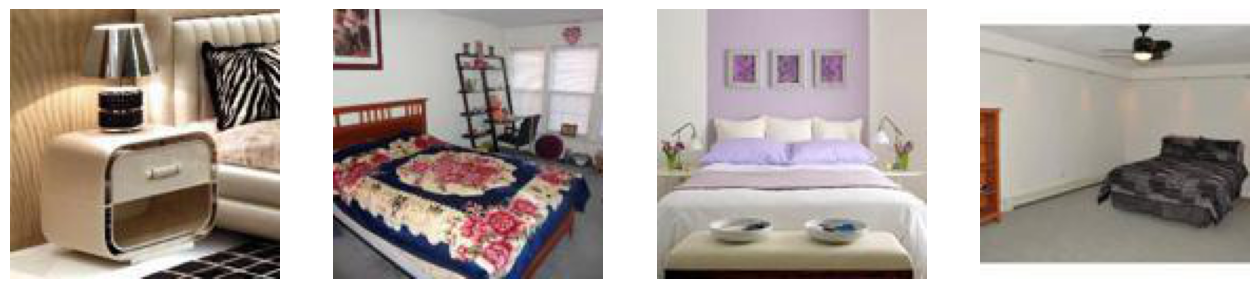

In [22]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [23]:
preprocess = transforms.Compose(
[
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [24]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

In [25]:
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)


In [26]:
model = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D"
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    )
)
model = model.to(device)

In [27]:
sample_image = dataset[0]["images"].unsqueeze(0).to(device)
print("Input shape", sample_image.shape)
print("Output shape", model(sample_image, timestep=0).sample.shape)

Input shape torch.Size([1, 3, 128, 128])
Output shape torch.Size([1, 3, 128, 128])


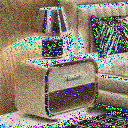

In [28]:
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TIMESTEPS)
noise = torch.randn(sample_image.shape).to(device)
timesteps = torch.LongTensor([50]).to(device)
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).cpu().numpy()[0])

In [29]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)

tensor(1.2002, device='cuda:0', grad_fn=<MseLossBackward0>)


In [30]:
def sample_image_generation(model, noise_scheduler, num_generate_images, random_seed, num_timesteps):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
    
    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images
    
    fig = plt.figure()
    for i in range(1, num_generate_images+1):
        fig.add_subplot(3, 3, i)
        plt.imshow(images[i-1])
    plt.show()

100%|██████████| 1895/1895 [13:46<00:00,  2.29it/s]

------------------------------
Train Loss EPOCH: 1: 0.0611
Train Learning Rate EPOCH: 1: 9.994595603558336e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

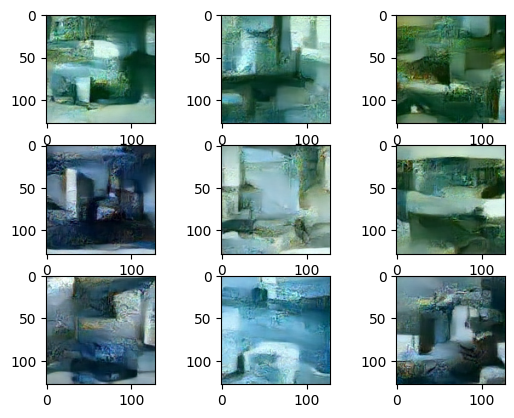

  2%|▏         | 1/50 [14:59<12:14:21, 899.22s/it]

------------------------------


  4%|▍         | 2/50 [27:07<10:38:51, 798.58s/it]

------------------------------
Train Loss EPOCH: 2: 0.0192
Train Learning Rate EPOCH: 2: 9.969964591327945e-05
------------------------------


  6%|▌         | 3/50 [39:38<10:08:27, 776.75s/it]

------------------------------
Train Loss EPOCH: 3: 0.0179
Train Learning Rate EPOCH: 3: 9.925510808779709e-05
------------------------------


  8%|▊         | 4/50 [52:10<9:47:59, 766.95s/it] 

------------------------------
Train Loss EPOCH: 4: 0.0171
Train Learning Rate EPOCH: 4: 9.861411560420533e-05
------------------------------


 10%|█         | 5/50 [1:03:43<9:15:23, 740.52s/it]

------------------------------
Train Loss EPOCH: 5: 0.0166
Train Learning Rate EPOCH: 5: 9.777922506960752e-05
------------------------------


 12%|█▏        | 6/50 [1:15:26<8:53:36, 727.64s/it]

------------------------------
Train Loss EPOCH: 6: 0.0155
Train Learning Rate EPOCH: 6: 9.675376645607974e-05
------------------------------


 14%|█▍        | 7/50 [1:26:59<8:33:29, 716.50s/it]

------------------------------
Train Loss EPOCH: 7: 0.0159
Train Learning Rate EPOCH: 7: 9.554182981903238e-05
------------------------------


 16%|█▌        | 8/50 [1:38:30<8:15:47, 708.27s/it]

------------------------------
Train Loss EPOCH: 8: 0.0152
Train Learning Rate EPOCH: 8: 9.414981364520634e-05
------------------------------


 18%|█▊        | 9/50 [1:50:09<8:02:01, 705.39s/it]

------------------------------
Train Loss EPOCH: 9: 0.0154
Train Learning Rate EPOCH: 9: 9.258032959172949e-05
------------------------------


 20%|██        | 10/50 [2:01:54<7:50:10, 705.27s/it]

------------------------------
Train Loss EPOCH: 10: 0.0151
Train Learning Rate EPOCH: 10: 9.084197476526741e-05
------------------------------


100%|██████████| 1895/1895 [11:53<00:00,  2.66it/s]

------------------------------
Train Loss EPOCH: 11: 0.0152
Train Learning Rate EPOCH: 11: 8.894089299796267e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

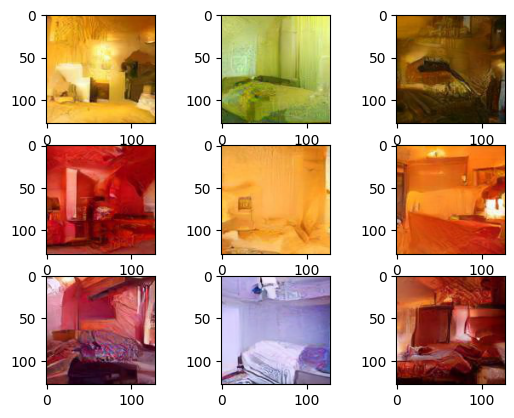

 22%|██▏       | 11/50 [2:15:04<7:55:18, 731.24s/it]

------------------------------


 24%|██▍       | 12/50 [2:26:16<7:31:42, 713.22s/it]

------------------------------
Train Loss EPOCH: 12: 0.0147
Train Learning Rate EPOCH: 12: 8.688465878203956e-05
------------------------------


 26%|██▌       | 13/50 [2:37:22<7:10:51, 698.70s/it]

------------------------------
Train Loss EPOCH: 13: 0.0148
Train Learning Rate EPOCH: 13: 8.468146478461414e-05
------------------------------


 28%|██▊       | 14/50 [2:48:24<6:52:37, 687.72s/it]

------------------------------
Train Loss EPOCH: 14: 0.0148
Train Learning Rate EPOCH: 14: 8.234008920559823e-05
------------------------------


 30%|███       | 15/50 [2:59:29<6:37:13, 680.95s/it]

------------------------------
Train Loss EPOCH: 15: 0.0147
Train Learning Rate EPOCH: 15: 7.986852424174209e-05
------------------------------


 32%|███▏      | 16/50 [3:10:32<6:22:46, 675.48s/it]

------------------------------
Train Loss EPOCH: 16: 0.0141
Train Learning Rate EPOCH: 16: 7.727922501096742e-05
------------------------------


 34%|███▍      | 17/50 [3:21:35<6:09:27, 671.75s/it]

------------------------------
Train Loss EPOCH: 17: 0.0145
Train Learning Rate EPOCH: 17: 7.458123698979744e-05
------------------------------


 36%|███▌      | 18/50 [3:32:37<5:56:42, 668.82s/it]

------------------------------
Train Loss EPOCH: 18: 0.0141
Train Learning Rate EPOCH: 18: 7.178530978913214e-05
------------------------------


 38%|███▊      | 19/50 [3:43:38<5:44:20, 666.47s/it]

------------------------------
Train Loss EPOCH: 19: 0.0143
Train Learning Rate EPOCH: 19: 6.890258323956976e-05
------------------------------


 40%|████      | 20/50 [3:54:45<5:33:20, 666.68s/it]

------------------------------
Train Loss EPOCH: 20: 0.0142
Train Learning Rate EPOCH: 20: 6.594454300690865e-05
------------------------------


100%|██████████| 1895/1895 [11:02<00:00,  2.86it/s]

------------------------------
Train Loss EPOCH: 21: 0.0142
Train Learning Rate EPOCH: 21: 6.29229748297355e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

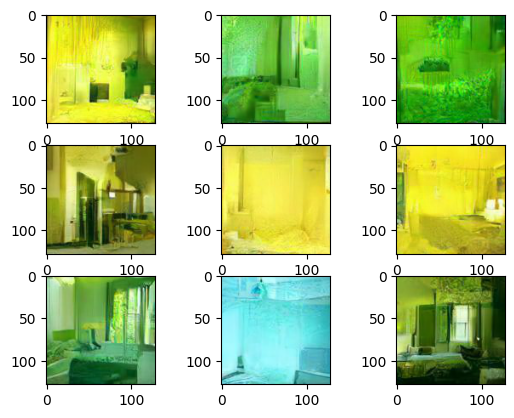

 42%|████▏     | 21/50 [4:06:57<5:31:38, 686.17s/it]

------------------------------


 44%|████▍     | 22/50 [4:17:59<5:16:52, 679.02s/it]

------------------------------
Train Loss EPOCH: 22: 0.0139
Train Learning Rate EPOCH: 22: 5.984991756143207e-05
------------------------------


 46%|████▌     | 23/50 [4:28:58<5:02:52, 673.07s/it]

------------------------------
Train Loss EPOCH: 23: 0.0140
Train Learning Rate EPOCH: 23: 5.673761520369464e-05
------------------------------


 48%|████▊     | 24/50 [4:39:57<4:49:46, 668.70s/it]

------------------------------
Train Loss EPOCH: 24: 0.0140
Train Learning Rate EPOCH: 24: 5.359846812267989e-05
------------------------------


 50%|█████     | 25/50 [4:51:06<4:38:39, 668.78s/it]

------------------------------
Train Loss EPOCH: 25: 0.0140
Train Learning Rate EPOCH: 25: 5.0444983642146915e-05
------------------------------


 52%|█████▏    | 26/50 [5:02:13<4:27:18, 668.28s/it]

------------------------------
Train Loss EPOCH: 26: 0.0134
Train Learning Rate EPOCH: 26: 4.72897262104472e-05
------------------------------


 54%|█████▍    | 27/50 [5:13:16<4:15:37, 666.84s/it]

------------------------------
Train Loss EPOCH: 27: 0.0139
Train Learning Rate EPOCH: 27: 4.4145267339912935e-05
------------------------------


 56%|█████▌    | 28/50 [5:24:18<4:03:56, 665.32s/it]

------------------------------
Train Loss EPOCH: 28: 0.0135
Train Learning Rate EPOCH: 28: 4.102413551810006e-05
------------------------------


 58%|█████▊    | 29/50 [5:35:19<3:52:26, 664.12s/it]

------------------------------
Train Loss EPOCH: 29: 0.0137
Train Learning Rate EPOCH: 29: 3.793714888643233e-05
------------------------------


 60%|██████    | 30/50 [5:46:23<3:41:20, 664.01s/it]

------------------------------
Train Loss EPOCH: 30: 0.0136
Train Learning Rate EPOCH: 30: 3.489986389723145e-05
------------------------------


100%|██████████| 1895/1895 [11:06<00:00,  2.85it/s]

------------------------------
Train Loss EPOCH: 31: 0.0136
Train Learning Rate EPOCH: 31: 3.192274247672264e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

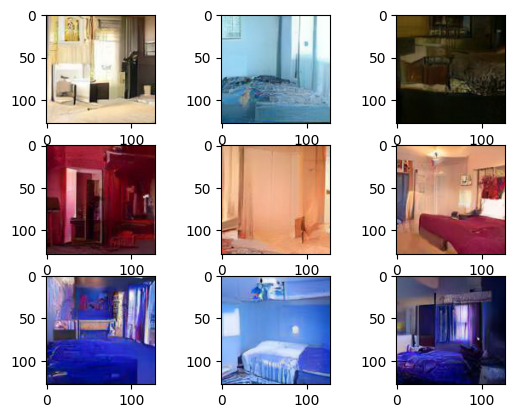

 62%|██████▏   | 31/50 [5:58:38<3:36:59, 685.25s/it]

------------------------------


 64%|██████▍   | 32/50 [6:09:41<3:23:35, 678.62s/it]

------------------------------
Train Loss EPOCH: 32: 0.0134
Train Learning Rate EPOCH: 32: 2.90176463887913e-05
------------------------------


 66%|██████▌   | 33/50 [6:20:56<3:11:55, 677.37s/it]

------------------------------
Train Loss EPOCH: 33: 0.0135
Train Learning Rate EPOCH: 33: 2.6196150426330268e-05
------------------------------


 68%|██████▊   | 34/50 [6:32:10<3:00:23, 676.46s/it]

------------------------------
Train Loss EPOCH: 34: 0.0135
Train Learning Rate EPOCH: 34: 2.3469496293718668e-05
------------------------------


 70%|███████   | 35/50 [6:43:16<2:48:18, 673.24s/it]

------------------------------
Train Loss EPOCH: 35: 0.0136
Train Learning Rate EPOCH: 35: 2.0847193779002534e-05
------------------------------


 72%|███████▏  | 36/50 [6:54:20<2:36:26, 670.48s/it]

------------------------------
Train Loss EPOCH: 36: 0.0130
Train Learning Rate EPOCH: 36: 1.834245762163837e-05
------------------------------


 74%|███████▍  | 37/50 [7:05:33<2:25:28, 671.45s/it]

------------------------------
Train Loss EPOCH: 37: 0.0134
Train Learning Rate EPOCH: 37: 1.5963854812513037e-05
------------------------------


 76%|███████▌  | 38/50 [7:16:46<2:14:21, 671.78s/it]

------------------------------
Train Loss EPOCH: 38: 0.0131
Train Learning Rate EPOCH: 38: 1.3719715589623466e-05
------------------------------


 78%|███████▊  | 39/50 [7:27:59<2:03:12, 672.07s/it]

------------------------------
Train Loss EPOCH: 39: 0.0133
Train Learning Rate EPOCH: 39: 1.1621348989577042e-05
------------------------------


 80%|████████  | 40/50 [7:39:12<1:52:03, 672.39s/it]

------------------------------
Train Loss EPOCH: 40: 0.0132
Train Learning Rate EPOCH: 40: 9.675894693807996e-06
------------------------------


100%|██████████| 1895/1895 [11:16<00:00,  2.80it/s]

------------------------------
Train Loss EPOCH: 41: 0.0133
Train Learning Rate EPOCH: 41: 7.890205366633757e-06


  0%|          | 0/1000 [00:00<?, ?it/s]

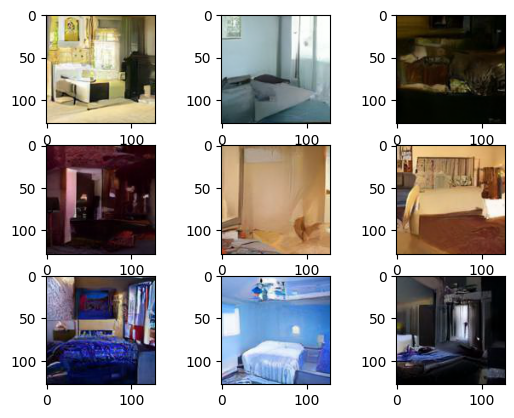

 82%|████████▏ | 41/50 [7:51:40<1:44:16, 695.16s/it]

------------------------------


 84%|████████▍ | 42/50 [8:02:54<1:31:50, 688.85s/it]

------------------------------
Train Loss EPOCH: 42: 0.0130
Train Learning Rate EPOCH: 42: 6.2732797483127385e-06
------------------------------


 86%|████████▌ | 43/50 [8:14:17<1:20:08, 686.95s/it]

------------------------------
Train Loss EPOCH: 43: 0.0132
Train Learning Rate EPOCH: 43: 4.8305747806957016e-06
------------------------------


 88%|████████▊ | 44/50 [8:25:35<1:08:25, 684.20s/it]

------------------------------
Train Loss EPOCH: 44: 0.0132
Train Learning Rate EPOCH: 44: 3.5678386423971146e-06
------------------------------


 90%|█████████ | 45/50 [8:36:52<56:50, 682.17s/it]  

------------------------------
Train Loss EPOCH: 45: 0.0133
Train Learning Rate EPOCH: 45: 2.4901024610756883e-06
------------------------------


 92%|█████████▏| 46/50 [8:48:16<45:31, 682.77s/it]

------------------------------
Train Loss EPOCH: 46: 0.0128
Train Learning Rate EPOCH: 46: 1.601660267880234e-06
------------------------------


 94%|█████████▍| 47/50 [8:59:30<33:59, 679.95s/it]

------------------------------
Train Loss EPOCH: 47: 0.0132
Train Learning Rate EPOCH: 47: 9.060518887140157e-07
------------------------------


 96%|█████████▌| 48/50 [9:10:43<22:36, 678.04s/it]

------------------------------
Train Loss EPOCH: 48: 0.0129
Train Learning Rate EPOCH: 48: 4.0604884048376925e-07
------------------------------


 98%|█████████▊| 49/50 [9:21:57<11:16, 676.71s/it]

------------------------------
Train Loss EPOCH: 49: 0.0131
Train Learning Rate EPOCH: 49: 1.0364328852718319e-07
------------------------------


100%|██████████| 50/50 [9:33:10<00:00, 687.80s/it]

------------------------------
Train Loss EPOCH: 50: 0.0131
Train Learning Rate EPOCH: 50: 4.010921585417826e-11
------------------------------
Training Time: 34390.22s


In [31]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_dataloader)*NUM_EPOCHS
)

accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)

start = timeit.default_timer()
for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    train_running_loss = 0
    for idx, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        clean_images = batch["images"].to(device)
        noise = torch.randn(clean_images.shape).to(device)
        last_batch_size = len(clean_images)
        
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
        
        with accelerator.accumulate(model):
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)
            
            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx+1)
    
    train_learning_rate = lr_scheduler.get_last_lr()[0]
    print("-"*30)
    print(f"Train Loss EPOCH: {epoch+1}: {train_loss:.4f}")
    print(f"Train Learning Rate EPOCH: {epoch+1}: {train_learning_rate}")
    if epoch%10 == 0:
        sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)
    print("-"*30)
    
stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

  0%|          | 0/1000 [00:00<?, ?it/s]

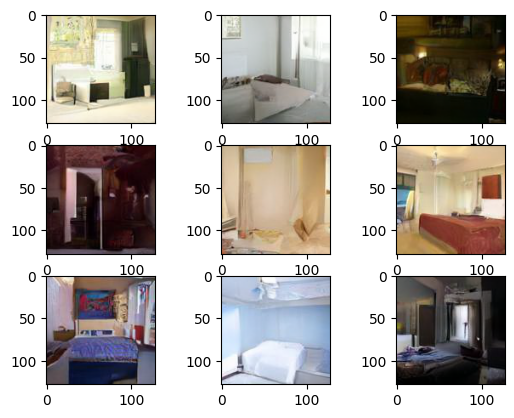

In [32]:
sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)


In [37]:
# save model with size, num_layers, num_channels, num_timesteps, num_epochs, learning_rate, mixed_precision, gradient_accumulation_steps and other metadata (metadata.json)
import os
import time
# save model with date and time in a folder
os.makedirs("models", exist_ok=True)
time = time.strftime('%Y-%m-%d_%H-%M-%S')
model_path = f"models/{time}"
os.makedirs(model_path, exist_ok=True)
torch.save(model.state_dict(), f"{model_path}/model.pth")

# save optimizer
torch.save(optimizer.state_dict(), f"{model_path}/optimizer.pth")

# save lr_scheduler
torch.save(lr_scheduler.state_dict(), f"{model_path}/lr_scheduler.pth")

# save noise_scheduler
torch.save(noise_scheduler, f"{model_path}/noise_scheduler.pth")



# save metadata
metadata = {
    "IMG_SIZE": IMG_SIZE,
    "BATCH_SIZE": BATCH_SIZE,
    "LEARNING_RATE": LEARNING_RATE,
    "NUM_EPOCHS": NUM_EPOCHS,
    "NUM_GENERATE_IMAGES": NUM_GENERATE_IMAGES,
    "NUM_TIMESTEPS": NUM_TIMESTEPS,
    "MIXED_PRECISION": MIXED_PRECISION,
    "GRADIENT_ACCUMULATION_STEPS": GRADIENT_ACCUMULATION_STEPS,
    "time": time
}
